In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [34]:
# importing datasets
full_table = pd.read_csv('E:/rohan/CSE 6/covid_19_clean_complete.csv/covid_19_clean_complete.csv', parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33,65,2020-01-22,0,0,0
1,NaN,Albania,41,20,2020-01-22,0,0,0
2,NaN,Algeria,28,2,2020-01-22,0,0,0
3,NaN,Andorra,43,2,2020-01-22,0,0,0
4,NaN,Angola,-11,18,2020-01-22,0,0,0


In [35]:
full_table

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33,65,2020-01-22,0,0,0
1,NaN,Albania,41,20,2020-01-22,0,0,0
2,NaN,Algeria,28,2,2020-01-22,0,0,0
3,NaN,Andorra,43,2,2020-01-22,0,0,0
4,NaN,Angola,-11,18,2020-01-22,0,0,0
5,NaN,Antigua and Barbuda,17,-62,2020-01-22,0,0,0
6,NaN,Argentina,-38,-64,2020-01-22,0,0,0
7,NaN,Armenia,40,45,2020-01-22,0,0,0
8,Australian Capital Territory,Australia,-35,149,2020-01-22,0,0,0
9,New South Wales,Australia,-34,151,2020-01-22,0,0,0


In [36]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed']]

In [57]:
country = 'China'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail()

,Confirmed
Date,
2020-05-14,84029
2020-05-15,84038
2020-05-16,84044
2020-05-17,84054
2020-05-18,84063


In [46]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [47]:
def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 0]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

In [48]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt

array([8.30861487e+04, 1.35677608e-01, 6.91406089e+00])

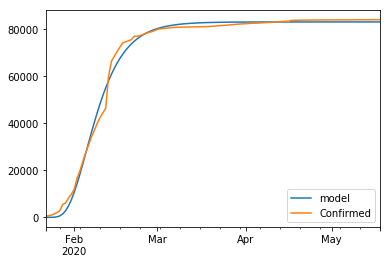

In [49]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['model']
pd.concat([model_sim, df], axis=1).plot()
plt.show()

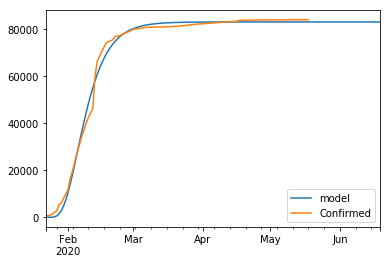

In [50]:
import datetime
start_date = df.index[0]
n_days = 150
extended_model_x = []
for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.concat([extended_model_sim, df], axis=1).plot()
plt.show()

In [51]:
df.tail()

,Confirmed
Date,
2020-05-14,84029
2020-05-15,84038
2020-05-16,84044
2020-05-17,84054
2020-05-18,84063


In [52]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 7 == 0].astype({'model': 'int32'})

,Confirmed,model
2020-01-28,"5,509",1452
2020-02-07,"34,110",35958
2020-02-14,"66,358",60813
2020-02-21,"75,550",73760
2020-02-28,"78,928",79365
2020-03-07,"80,770",81813
2020-03-14,"80,977",82591
2020-03-21,"81,305",82894
2020-03-28,"81,999",83011
2020-04-07,"82,718",83067


In [53]:
def display_fit(df, opt, ax):
    model_x = []
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt, t)])
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['model']
    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

def display_extended_curve(df, opt, ax):
    start_date = df.index[0]
    n_days = 140
    extended_model_x = []
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['model -> ' + str(int(opt[0]))]
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

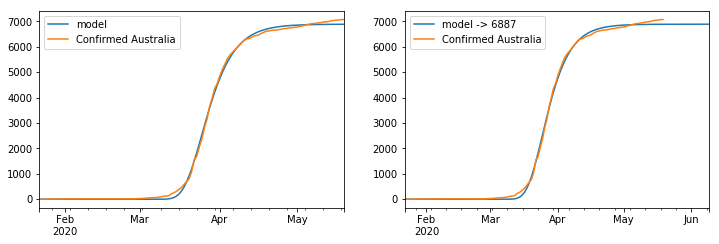

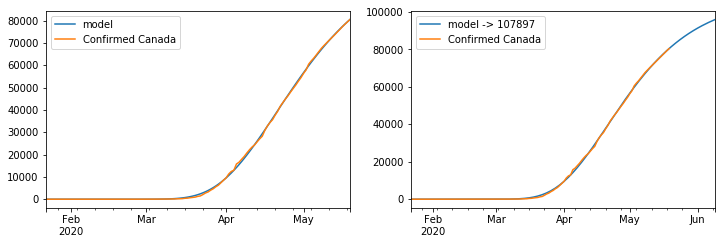

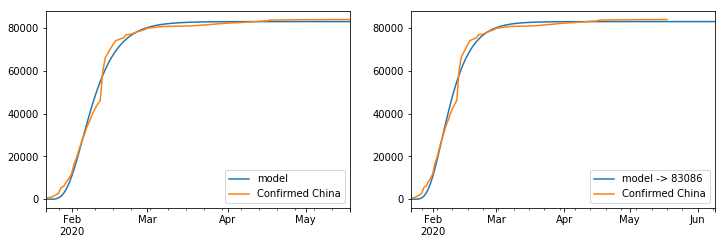

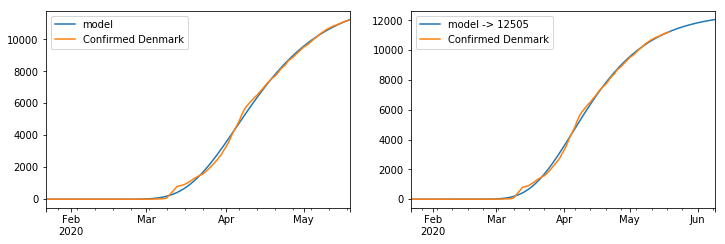

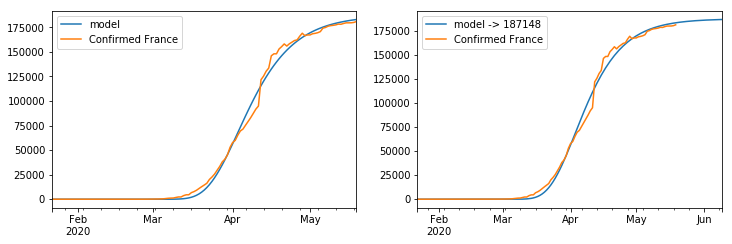

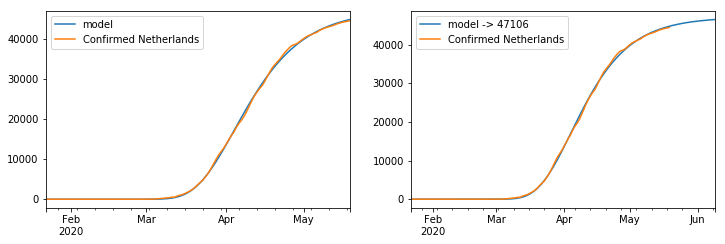

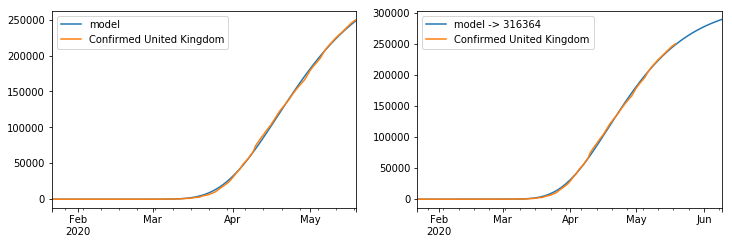

In [54]:
stats = []
for country in full_table['Country/Region'].unique():
# for country in ['Sweden']:
    df = get_time_series(country)
    # only consider countries with at least 5000 cases (plus Sweden)
    if len(df) == 0 or (max(df['Confirmed']) < 5000 and country != 'Sweden'): 
        continue
    df.columns = [df.columns[0] + ' ' + country]
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
#     if country == 'France':
#         display(df.tail())
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
#     print(country, opt)
    if min(opt) > 0:
        stats.append([country, *opt])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt, ax2)
        plt.show()
stats_df = pd.DataFrame(stats)
# stats_df.columns = ['country', 'N', 'a', 'alpha', 'lag']
stats_df.columns = ['country', 'N', 'a', 'alpha']

In [55]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'N': 'int'}).sort_values(by='N', ascending=False)

,country,N,a,alpha
6,United Kingdom,316364,0.0468,59.6442
4,France,187148,0.0830,399.0777
1,Canada,107897,0.0436,50.0362
2,China,83086,0.1357,6.9141
5,Netherlands,47106,0.0664,129.2555
3,Denmark,12505,0.0510,43.8979
0,Australia,6887,0.1421,"7,731.4107"


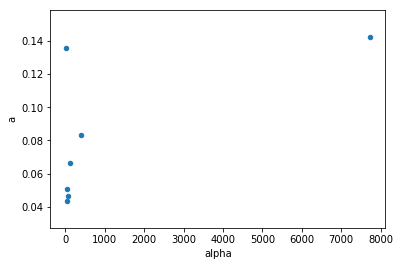

In [56]:
ax = stats_df.plot.scatter(x='alpha', y='a')
# ax.set_xlim([0, 100])
plt.show()